In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install optuna
# !pip install optuna_integration

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import wandb
wandb.init(mode="disabled")
# import optuna
# from optuna.integration import PyTorchLightningPruningCallback

In [12]:
train = pd.read_csv("./CSV-Dataset/with-remove-stopwords/train_data.csv")
test = pd.read_csv("./CSV-Dataset/with-remove-stopwords/test_data.csv")

# **XLM-RoBERTa**

In [13]:
# Load tokenizer and model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(train['labels'].unique()),
    classifier_dropout=0.3  # Add dropout for regularization
)

/mnt/e/Environment/pytorch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Encode labels
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train['labels'])
test_labels_encoded = le.transform(test['labels'])

print("Encoded Labels:", train_labels_encoded)
print("Mapping (Label -> Angka):")
for i, label in enumerate(le.classes_):
    print(f"{label} -> {i}")

Encoded Labels: [7 8 5 ... 7 3 3]
Mapping (Label -> Angka):
Infrastruktur dan Fasilitas Umum -> 0
Keadilan Hukum dan HAM -> 1
Kepegawaian -> 2
Kesehatan -> 3
Ketenagakerjaan dan Kesejahteraan Sosial -> 4
Lingkungan Hidup -> 5
Pendidikan -> 6
Perizinan dan Pertanahan -> 7
Teknologi Informasi dan Komunikasi -> 8


In [15]:
# Tokenize data
train_encodings = tokenizer(list(train['combined']), truncation=True, padding=True)
test_encodings = tokenizer(list(test['combined']), truncation=True, padding=True)

In [16]:
# Define dataset
class ComplaintDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ComplaintDataset(train_encodings, list(train_labels_encoded))
test_dataset = ComplaintDataset(test_encodings, list(test_labels_encoded))

In [ ]:
# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
# Define model initialization for hyperparameter search
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(train['labels'].unique()),
        classifier_dropout=0.3  # Regularization
    )

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Semester 5/Deep Learning/Tugas Final/xlm-roberta/results',
    evaluation_strategy="epoch",            # Evaluate at each steps
    save_strategy="epoch",                 # Save at each steps
    save_total_limit=2,                    # Keep only last 2 checkpoints
    learning_rate=2e-5,                    # Initial learning rate
    per_device_train_batch_size=16,        # Batch size for training
    per_device_eval_batch_size=16,         # Batch size for evaluation
    num_train_epochs=5,                    # Total number of training epochs
    weight_decay=0.01,                     # Weight decay for regularization
    load_best_model_at_end=True,           # Load the best model at the end
    metric_for_best_model="f1",            # Optimize for F1 score
    fp16=True,                             # Mixed precision training
    gradient_accumulation_steps=4,         # Simulate larger batch size
    lr_scheduler_type="cosine",            # Cosine learning rate scheduler
    warmup_steps=500,                      # Warmup steps for learning rate
    push_to_hub=False,
    report_to='none'
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
# # Hyperparameter tuning with Optuna
# best_trial = trainer.hyperparameter_search(
#     direction="maximize",
#     n_trials=5,  # Number of trials for hyperparameter search
#     backend="optuna"
# )
# print("Best trial:", best_trial)

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.832512,0.409027,0.323496
2,No log,0.717501,0.812882,0.811751
3,No log,0.587301,0.836389,0.836063
4,1.219600,0.571235,0.838740,0.838252
5,1.219600,0.504000,0.858956,0.858448


TrainOutput(global_step=665, training_loss=1.021562481643562, metrics={'train_runtime': 1299.462, 'train_samples_per_second': 32.733, 'train_steps_per_second': 0.512, 'total_flos': 1.119213212299776e+16, 'train_loss': 1.021562481643562, 'epoch': 5.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/Semester 5/Deep Learning/Tugas Final/xlm-roberta/xlm-roberta-best")

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

In [17]:
from transformers import AutoModelForSequenceClassification, Trainer


# Load the saved model
model_path = "./xlm-roberta-best"
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)

trainer = Trainer(model=loaded_model)

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Generate the classification report
print(classification_report(test_labels_encoded, predicted_labels, target_names=le.classes_))

                                          precision    recall  f1-score   support

        Infrastruktur dan Fasilitas Umum       0.84      0.93      0.89       187
                  Keadilan Hukum dan HAM       0.86      0.72      0.79       163
                             Kepegawaian       0.80      0.85      0.82       316
                               Kesehatan       0.89      0.83      0.86       263
Ketenagakerjaan dan Kesejahteraan Sosial       0.89      0.89      0.89       440
                        Lingkungan Hidup       0.76      0.76      0.76       115
                              Pendidikan       0.85      0.84      0.85       243
                Perizinan dan Pertanahan       0.87      0.88      0.87       226
      Teknologi Informasi dan Komunikasi       0.91      0.95      0.93       174

                                accuracy                           0.86      2127
                               macro avg       0.85      0.85      0.85      2127
              

In [ ]:
# Calculate metrics
f1 = f1_score(test_labels_encoded, predicted_labels, average='weighted')
accuracy = accuracy_score(test_labels_encoded, predicted_labels)
recall = recall_score(test_labels_encoded, predicted_labels, average='weighted')
precision = precision_score(test_labels_encoded, predicted_labels, average='weighted')

print(f"F1-score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

# Generate the classification report (optional, already present in the code)
print(classification_report(test_labels_encoded, predicted_labels, target_names=le.classes_))

F1-score: 0.8584476773926224
Accuracy: 0.8589562764456982
Recall: 0.8589562764456982
Precision: 0.8598059764015854
                                          precision    recall  f1-score   support

        Infrastruktur dan Fasilitas Umum       0.84      0.93      0.89       187
                  Keadilan Hukum dan HAM       0.86      0.72      0.79       163
                             Kepegawaian       0.80      0.85      0.82       316
                               Kesehatan       0.89      0.83      0.86       263
Ketenagakerjaan dan Kesejahteraan Sosial       0.89      0.89      0.89       440
                        Lingkungan Hidup       0.76      0.76      0.76       115
                              Pendidikan       0.85      0.84      0.85       243
                Perizinan dan Pertanahan       0.87      0.88      0.87       226
      Teknologi Informasi dan Komunikasi       0.91      0.95      0.93       174

                                accuracy                       

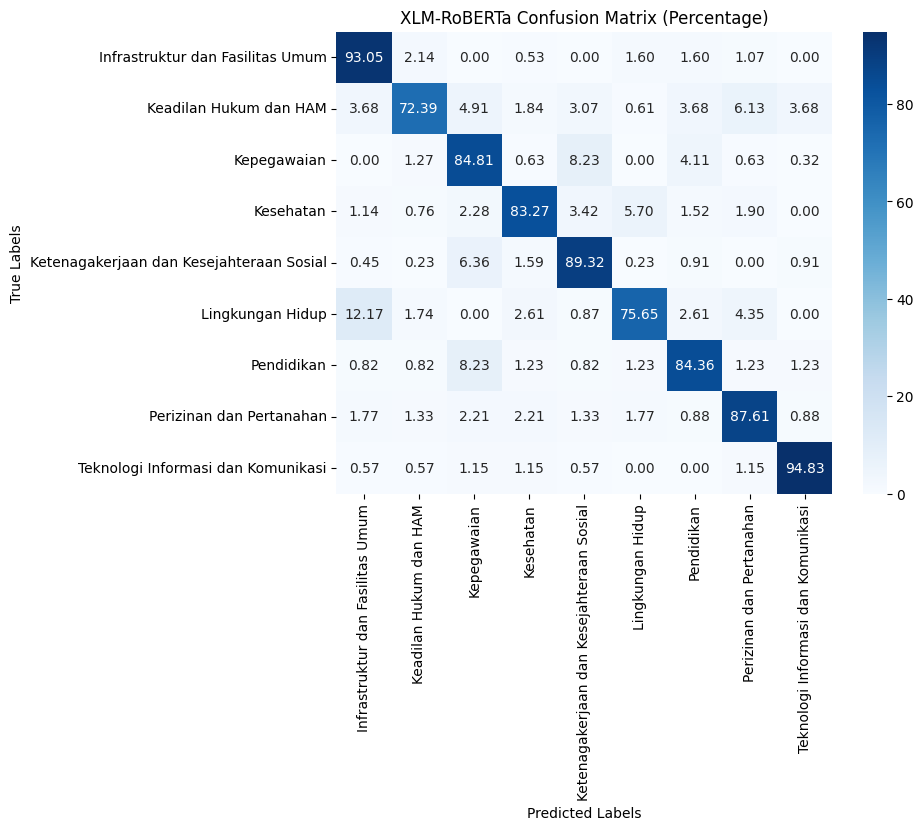

In [30]:
cm = confusion_matrix(test_labels_encoded, predicted_labels)

# Calculate the percentage for each cell
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix as percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("XLM-RoBERTa Confusion Matrix (Percentage)")
plt.show()

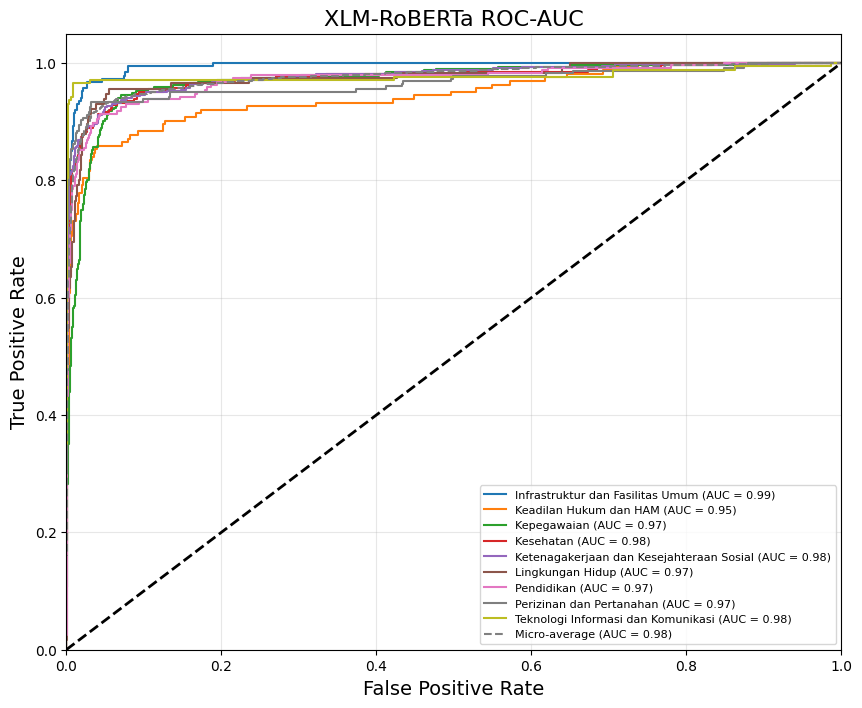

In [ ]:
#  Predict probabilities
probabilities = predictions.predictions
n_classes = probabilities.shape[1]

# Binarize the test labels for multi-class ROC
test_labels_binarized = label_binarize(test_labels_encoded, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_binarized.ravel(), probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10.colors  # Use a colormap for better visualization

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot(fpr["micro"], tpr["micro"], linestyle="--", color="gray",
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('XLM-RoBERTa ROC-AUC', fontsize=16)
plt.legend(loc="lower right", fontsize=8)
plt.grid(alpha=0.3)
plt.show()
